In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta
from sqlalchemy import cast, Date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).distinct().first()
print("Last Date: ", last_date)

Last Date:  ('2017-08-23',)


In [30]:
latestdate = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

datetime.date(2016, 8, 23)

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the data 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > querydate).\
    order_by(Measurement.date).all()
df = pd.DataFrame(data=query).sort_values(by=['date'])
df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


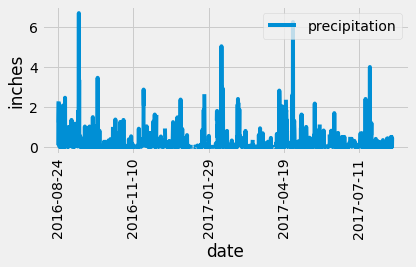

In [14]:
df.plot(x='date', y='prcp')
plt.xticks(rotation='vertical')
plt.ylabel('inches')
plt.legend(['precipitation'],loc='upper right')
plt.tight_layout()

In [15]:
query = session.query(Measurement.station, Measurement.prcp, Measurement.date).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()
df = pd.DataFrame(data=query).sort_values(by=['date'])
df.head()

,station,prcp,date
0,USC00519397,0.08,2016-08-24
1,USC00513117,2.15,2016-08-24
2,USC00514830,2.28,2016-08-24
3,USC00517948,NaN,2016-08-24
4,USC00519523,1.22,2016-08-24


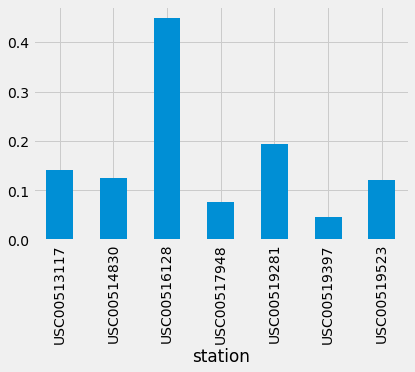

In [16]:
df.groupby('station')['prcp'].mean().plot(kind='bar')

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = (session.query(func.count(Station.name)).all())[0][0]
print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.query(Measurement.station, Station.name, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).limit(1).all()
lowest_temp = session.query(func.min(Measurement.tobs)).all()[0][0]
highest_temp = session.query(func.max(Measurement.tobs)).all()[0][0]
avg_temp = session.query(func.avg(Measurement.tobs)).all()[0][0]

print(f'Most active station is {most_active_station[0][0]}, {most_active_station[0][1]}')

print(f'Lowest temperature recorded is {lowest_temp}')
print(f'Highest temperature recorded is {highest_temp}')
print(f'Average temperature is {avg_temp}')
      

Most active station is USC00519281, WAIKIKI 717.2, HI US
Lowest temperature recorded is 53.0
Highest temperature recorded is 87.0
Average temperature is 73.09795396419437


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_temp_station = session.query(Station.name, Measurement.station, func.max(Measurement.tobs)).all()
print(f'Station with the highest temperature is {highest_temp_station[0][0]}')

Station with the highest temperature is WAIKIKI 717.2, HI US


In [22]:
highest_temp_station = highest_temp_station[0][1]

In [23]:
query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == highest_temp_station).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date.desc()).all()
df = pd.DataFrame(query)
df.head()


,date,tobs
0,2017-08-23,81.0
1,2017-08-22,82.0
2,2017-08-21,81.0
3,2017-08-20,81.0
4,2017-08-19,79.0


Text(0.5, 0, 'Temperature')

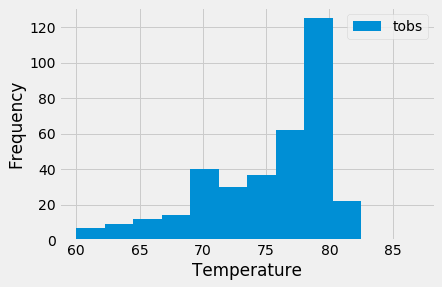

In [24]:
ax = df.plot.hist(bins=12)
ax.set_xlabel('Temperature')

## Bonus Challenge Assignment

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [36]:
start_date = querydate
end_date = querydate
tempresult = calc_temps(start_date,end_date)[0]
tempresult

(74.0, 78.28571428571429, 81.0)

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr) 
## yerr = tmax-tmin 

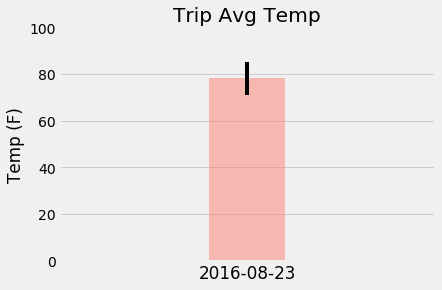

In [67]:
xaxis = [0]
yaxis = [tempresult[1]]
yerr = [tempresult[2]-tempresult[0]]

plt.bar(xaxis, yaxis, yerr=yerr, color='salmon', alpha = 0.5)
plt.title("Trip Avg Temp")
plt.xlabel(querydate)
plt.ylabel("Temp (F)")
plt.xlim(-2, 2)
plt.ylim(0, 100)
plt.grid(which='major', axis='x', linestyle='')
plt.tick_params(labelbottom=False)
plt.show()

In [51]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
